## Regularization: application with medical microbiology diagnosis

We want to predict the IBD (Inflammatory Bowel Disease) clinical status of patients **given the abundance of microbial species** living in their gut.

Each patient is assigned to a clinical status, and the abundances of known species in their gut are reported in a matrix of size `patient x species`.

We focus here on the seminal metagenomic study by Nielsen H.B. et al, published in 2014.



*Student name: PHAN MANH TUNG*

*Class: MOSIG M1*

*Student number: 42202349*


In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score

# Viz
import matplotlib.pyplot as plt

In [2]:
# Load the data
ab_data_pd = pd.read_csv("/content/gut_abundances.tsv", sep="\t", header = 0)
descriptor_names = ab_data_pd.columns
ab_data = ab_data_pd.to_numpy()
status_txt =  pd.read_csv("/content/ibd_status.lst", sep="\t", header = None).to_numpy()
ab_data_pd

,k__Bacteria,k__Archaea,k__Viruses,k__Bacteria|p__Bacteroidetes,k__Bacteria|p__Firmicutes,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Actinobacteria,k__Archaea|p__Euryarchaeota,k__Bacteria|p__Verrucomicrobia,k__Viruses|p__Viruses_noname,...,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae,k__Viroids|p__Viroids_noname|c__Viroids_noname|o__Viroids_noname|f__Pospiviroidae|g__Pospiviroidae_noname,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Leifsonia,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Ectothiorhodospiraceae|g__Thioalkalivibrio,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Labrenzia,k__Viroids|p__Viroids_noname|c__Viroids_noname|o__Viroids_noname|f__Pospiviroidae|g__Pospiviroidae_noname|s__Dahlia_latent_viroid,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Leifsonia|s__Leifsonia_unclassified,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Ectothiorhodospiraceae|g__Thioalkalivibrio|s__Thioalkalivibrio_unclassified,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Labrenzia|s__Labrenzia_unclassified,k__Viroids|p__Viroids_noname|c__Viroids_noname|o__Viroids_noname|f__Pospiviroidae|g__Pospiviroidae_noname|s__Dahlia_latent_viroid|t__PRJNA186953
MH0001,99.85542,0.12024,0.02435,75.76233,22.45185,0.79821,0.77138,0.12024,0.04902,0.02435,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MH0002,99.84094,0.00000,0.15906,29.66601,63.00964,0.80546,1.31857,0.00000,5.02320,0.15906,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MH0003,99.99769,0.00000,0.00231,28.89089,68.87499,1.10182,1.11216,0.00000,0.00000,0.00231,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MH0004,99.54958,0.44427,0.00615,36.82369,59.90264,0.96707,1.79713,0.44427,0.00000,0.00615,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MH0005,99.85338,0.02338,0.12324,53.45066,44.00230,0.66402,1.34265,0.02338,0.33886,0.12324,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V1_UC61_0,100.00000,0.00000,0.00000,73.60036,23.13241,1.97125,1.29598,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
V1_UC62_0,99.43677,0.53534,0.02789,59.81443,31.16507,1.25950,7.12218,0.53534,0.07560,0.02789,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
V1_UC7_0,99.97056,0.00000,0.02944,61.47615,31.97288,3.65580,1.59657,0.00000,1.25953,0.02944,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
V1_UC8_0,96.71485,3.21396,0.01313,26.64142,56.61496,0.68027,7.95935,3.21396,4.79898,0.01313,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [3]:
# NOTE: 
# rows: people
# columns: different type of bacterias/viruses -> higher the number, higher the abundance

In [4]:
ab_data_pd.shape

(396, 1939)

Take a look at the data: number of samples ($n$), number of descriptors ($p$), names of descriptors (in ```descriptor_names```), etc.

In [5]:
n,p =ab_data_pd.shape
print("Data shape:",n,p)

Data shape: 396 1939


We now transform the target variable to a binary (0 ==  control, 1 == IBD) variable ```status```:

In [6]:
status = np.ravel([int(s == "IBD") for s in status_txt])

What is the name of the most correlated species (we denote by S) to the clinical status? Use the ```np.corrcoef``` function to compute the correlation between the data and the status.
You can compute the correlation between the data and the status using ```corr_vector = np.corrcoef(ab_data.transpose(),status))[:-1,p]```, which gives the correlation for each species.

In [7]:
#TO COMPLETE
corr_vector = np.corrcoef(ab_data.transpose(), status)[:-1,p]

In [8]:
# Create a list of [(bacteria_name, corr_vector)]
bac_name_corr_list = list(zip(range(len(corr_vector)),ab_data_pd.columns, corr_vector))

# Find the most correlated species
# Sort the list by corr_vector
cor_max = sorted(bac_name_corr_list, key=lambda x: x[2], reverse=True)[0]
cor_min = sorted(bac_name_corr_list, key=lambda x: x[2])[0]

print("Max Corr : ", cor_max)
print()
print("Min Corr : ", cor_min)

Max Corr :  (6, 'k__Bacteria|p__Actinobacteria', 0.40722498985588496)

Min Corr :  (152, 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Subdoligranulum|s__Subdoligranulum_unclassified', -0.2765710395434451)


Create a (naïve) predictor that takes as input the abundance of S and output the clinical status of the patient. Either compute the prediction accuracy or its AUC ROC for every threshold, this will be our baseline predictor to improve on.

(316, 1939)
(396, 1939)
6


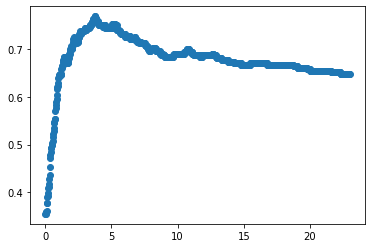

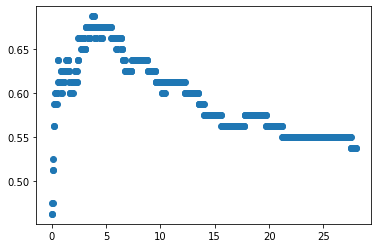

AUC ROC on test set: 0.6753614079195475


In [9]:
# The idea is to only use the most significant bac (S) to predict

# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(
    ab_data, status, test_size=0.2, shuffle=True
)
print(x_train.shape)
print(ab_data.shape)

# We remove species not abundant in the train set
col_to_rm = np.where(np.sum(x_train,axis=0) == 0)
x_train = np.delete(x_train,col_to_rm,axis=1)
x_test =  np.delete(x_test,col_to_rm,axis=1)
n,p = x_train.shape

# Index of the best correlated species to patient's status
best_cor_sp = cor_max[0]
print(best_cor_sp)

# Compute accuracy 
accuracy = list()
ths = np.linspace(0,int(np.max(x_train[:,best_cor_sp]))+1,1000) # threshold list
for t in ths:
    predictions = (x_train[:,best_cor_sp]>t)
    accuracy += [sum( predictions == y_train ) / len(y_train)]
    
# Plot the decision threshold vs. performance of the predictor
plt.scatter(ths,accuracy)
plt.show()

# "Real" accuracy on test set
# Decision threshold corresponding to the best accuracy.
best_ths = sorted(list(zip(ths,accuracy)), key=lambda x: x[1], reverse=True)[0][0]
# Report the accuracy on the test set
accuracy = list()
ths = np.linspace(0,int(np.max(x_test[:,best_cor_sp]))+1,1000) # threshold list
for t in ths:
    predictions = (x_test[:,best_cor_sp]>t)
    accuracy += [sum( predictions == y_test ) / len(y_test)]

plt.scatter(ths,accuracy)
plt.show()

# ROC AUC score of the best threshold
predictions = (x_test[:,best_cor_sp]>best_ths)
roc = roc_auc_score(y_test, predictions)
print("AUC ROC on test set:",roc)

Now we hope that we can do better when using more than 1 descriptor.

We will first use a standard [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Use the [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html ) function of Sklearn to evaluate your predictor in a cross-validation way.

Take a look at what metrics you can find in the attributes of the cross-validation object `cv` and print the average accuracy.

Do you gain in terms of accuracy compared to a single predictor? Check if you are overfitting the data.

In [10]:
logreg = linear_model.LogisticRegression(solver="liblinear")
cv = 5

test_score = cross_validate(logreg, ab_data, status, cv=cv)['test_score']
print("Average Cross-Validation accuracy on test:",test_score.mean())

# ??? no need for this, cross_validate() function carries all the job
# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(
    ab_data, status, test_size=0.5, shuffle=True
)

# Print example accuracy on 1 fold
cv=2
test_score = cross_validate(logreg, ab_data, status, cv=cv)['test_score']
print("Average Cross-Validation accuracy on test (2 folds):",test_score.mean())


Average Cross-Validation accuracy on test: 0.7525632911392404
Average Cross-Validation accuracy on test (2 folds): 0.7323232323232323


Check the `coef_` attribute of your model. How many species are you using for taking the decision?

In [11]:
# Create a DataFrame with descriptor names and coefficent values

df = pd.DataFrame(logreg.fit(ab_data, status).coef_[0], 
             descriptor_names, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False).reset_index()

df

,index,coef
0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,1.027397
1,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,1.027397
2,k__Bacteria|p__Firmicutes|c__Negativicutes|o__...,0.787720
3,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,0.745646
4,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,0.745646
...,...,...
1934,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...,-0.522123
1935,k__Bacteria|p__Firmicutes|c__Negativicutes|o__...,-0.590309
1936,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,-0.654919
1937,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,-0.779221


In [12]:
# A total of 1939 descriptors
# ??? threshold
# The chosen threshold is 1 standard deviation away from the mean (mean +- 1_std)
above_ths = df['coef'].mean() + df['coef'].std()
below_ths = df['coef'].mean() - df['coef'].std()

used_descriptors = df.loc[np.where( (df['coef'] <= below_ths) | (df['coef'] >= above_ths) ) ]
print("The model uses ",len(used_descriptors),"descriptors")

The model uses  280 descriptors


In [13]:
used_descriptors

,index,coef
0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,1.027397
1,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,1.027397
2,k__Bacteria|p__Firmicutes|c__Negativicutes|o__...,0.787720
3,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,0.745646
4,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,0.745646
...,...,...
1934,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...,-0.522123
1935,k__Bacteria|p__Firmicutes|c__Negativicutes|o__...,-0.590309
1936,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,-0.654919
1937,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,-0.779221


Considering that only few bacterial species may be responsible for IBD, choose a relevant regularization (see the available penalties for logistic regression [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).



In [14]:
# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(
    ab_data, status, test_size=0.5, shuffle=True
)

# Create a regularized model
logreg_regul =linear_model.LogisticRegression(solver='liblinear', penalty='l1') # l1, l2
logreg_regul.fit(x_train,y_train)
pred = logreg_regul.predict(x_test)

# Report accuracy on test set
from sklearn.metrics import accuracy_score
accuracy_score(pred, y_test)

0.7373737373737373

Have you increased the accuracy? Looking at `logreg_regul.coef_`, how many descriptors are you using after regularization?
All things considered, is it a better model?

In [15]:
df = pd.DataFrame(logreg_regul.fit(ab_data, status).coef_[0], 
             descriptor_names, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False).reset_index()

above_ths = df['coef'].mean() + df['coef'].std()
below_ths = df['coef'].mean() - df['coef'].std()

used_descriptors = df.loc[np.where( (df['coef'] <= below_ths) | (df['coef'] >= above_ths) ) ]
print("The model uses ",len(used_descriptors),"descriptors")

# Only 71 most significant descriptors (based on the given thresholds) 
# compared to 280 descriptors of the model without regularization

The model uses  71 descriptors


Remember that equivalent accuracy, but with fewer descriptors => more robust and explainable => better model !

Find the optimal regularization strength, by comparing performances on test set and train set. If you have more time, best is to do it by plotting the mean performance in cross-validation, with confidence enveloppe (+/- std deviation) over the folds.


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

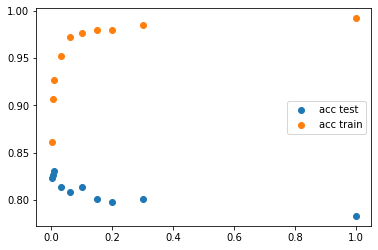

In [16]:
# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(
    ab_data, status, test_size=0.5, shuffle=True
)

acc_test = list()
acc_train = list()

reg_strengths = [0.001,0.005,0.01,0.03,0.06,0.1,0.15,0.2,0.3,1]
for c in reg_strengths:
    # Implementation with the cross validation: 
    # logreg1 performs the training with train set
    logreg1 = linear_model.LogisticRegression(C=c).fit(x_train, y_train)

    # logreg2 performs the training with test set
    logreg2 = linear_model.LogisticRegression(C=c).fit(x_test, y_test)
    cv = 2

    # logreg1 test with test set, logreg2 tests with train set; and vice versa; then I take the average of the 2
    acc_test += [(accuracy_score(logreg1.predict(x_test), y_test) + accuracy_score(logreg2.predict(x_train), y_train)) / cv]
    acc_train += [(accuracy_score(logreg1.predict(x_train), y_train) + accuracy_score(logreg2.predict(x_test), y_test)) / cv]

plt.clf()
plt.scatter(reg_strengths, acc_test, label='acc test')
plt.scatter(reg_strengths,acc_train, label='acc train')
plt.legend()
plt.show()

Train a classifier on the full dataset with the optimial regularization strength, and interpret the coefficients. You can check in particular if it is consistent with [this paper](https://pubmed.ncbi.nlm.nih.gov/27999802/) and [this one](https://pubmed.ncbi.nlm.nih.gov/20648002/).

In [17]:
# The graph show that if the training set perfectly fit, 
# the test set will have very low accuracy score due to overfitting

# c is the optimal penalty given the previous graph (hard-code this number)
c = 0.01 
# The smallest penalty score best performs in the test set (the third dot)
logreg = linear_model.LogisticRegression(C=c)
logreg.fit(ab_data,status)

descriptor_pd = pd.DataFrame({'name':descriptor_names, 'coef':logreg.coef_[0]}, columns=['name', 'coef']).sort_values(by="coef", ascending=False)
descriptor_pd

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,name,coef
164,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,0.085362
265,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,0.085362
311,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,0.075911
218,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,0.075911
894,k__Bacteria|p__Firmicutes|c__Negativicutes|o__...,0.072067
...,...,...
415,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,-0.074889
369,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,-0.076180
262,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,-0.086824
160,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,-0.094915


In [18]:
# positive association IBD, you can make use of numpy argsort function
print("Top 3 positive descriptors : ",descriptor_pd.head(3)['name'].tolist())

# negative association with IBD
print("Top 3 negative descriptors : ",descriptor_pd.tail(3)['name'].tolist())

Top 3 positive descriptors :  ['k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_comes', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_comes|t__GCF_000155875', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_1_1_57FAA|t__GCF_000218445']
Top 3 negative descriptors :  ['k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Ruminococcus_torques|t__Ruminococcus_torques_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Ruminococcus_torques', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia']


## Optional: other classifiers

Use other models for supervised classification (decision trees, SVM, neural nets, etc.) with the IBD data. Evaluate properly the performances, and pay attention to regularization!

